# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from thermostability.thermo_pregenerated_dataset import ThermostabilityPregeneratedDataset
from util.telegram import TelegramBot

cudnn.benchmark = True

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

telegramBot = TelegramBot()
telegramBot.enabled=False

# Defining datasets (train/validation) 

In [2]:
trainSet = ThermostabilityPregeneratedDataset("train.csv", limit=1024, usePerProteinRep=True)
valSet = ThermostabilityPregeneratedDataset("val.csv", limit=12, usePerProteinRep=True)

dataloaders = {
    "train": torch.utils.data.DataLoader(trainSet, batch_size=2, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(valSet, batch_size=2, shuffle=True, num_workers=4)
}

dataset_sizes = {"train": len(trainSet),"val": len(valSet)}
print(dataset_sizes)

Omitted 45385 sequences of train.csv because they have not been pregenerated
Omitted 4660 sequences of val.csv because they have not been pregenerated
{'train': 12, 'val': 12}


In [3]:
print(next(enumerate(dataloaders["train"])))

(0, [('MKDVVIQTVSANRHNYTKLAMVQFDTAAGLENITYFDDVLSFSSALNSNPPNSKNAASSTQTSDVLSVVSGFLAASGRPLESSMVVLLVNRWPAANADLTSSEYDTITNNNVKIFPISSANSYVQQIPIVTASAKIFTTLAANSNAHFVLGDYGKPLAQVFQYLMGTAYLDSLTITRSFADRTNAAQKQIGKLRVPHSETQSYVNFTITISVGLNGWGNFNYPNTNGIEVTFYQSQANQKTVQFEPGSLQGTNFYYATVQLKESSTYQVIYQSSLIDGSVAMVRVWTTSALYHYGSYATLEDPMGGNTLDKVDEYQGAALRMKLMNDCYTSHAGYAVFTDCTGAVSSKYDASQTIPIDYIFADEGSFPHYPIVPFFCDSKPKSTVDCVPGTESKYDIQFVAGEFIVNRSFQCRPGVGQINPNCTNVDSNGNYYCNRDQLPYMRGPTGQIPDCLGHGHVEYDFAFAEAYICVCDNSYSGDSCQIKN', 'MEHKGKNDFHSEWAKSIKELMLSLHEYVRQHHTTGLVWNSDPGATPMCNRKSGGAPTPPPPPPPPISLIAPSKPSGVGALLESLNTGLSATSRLKKVTPEMQTHKNPVLREVNGQMNRKTEERKVSENKKPEKIHESSIFWDGKIWKVDHQVGNKNAVVEVTDKKESIYIYKCNDSIIKIKGKANAITLDGCRKTSVVFDGLVAQCEIINCQSIQIQTLGELPTVSIQKTDGCHIYLSRDALNAQIVASKSSEMNISAMLEDGDDEYTEMALPEQFMTKIVGKKLVTVASEIV'), tensor([50.7222, 42.6682])])


# Defining model 

In [8]:
from thermostability.hotinfer import HotInferModelParallel
from thermostability.hotinfer_pregenerated import HotInferPregeneratedFC 

representation_key = "s_s_0_avg"


model = HotInferPregeneratedFC(input_len=1024, num_hidden_layers=3, first_hidden_size=1024).to("cuda:0")


1024
512


# Setup training

In [9]:
from tqdm.notebook import tqdm
import sys
from util.train import train_model

# Define training parameters

In [10]:
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

Epoch 0/99
----------
original s_s shapeoriginal s_s shape original s_s shape  torch.Size([466, 1024])original s_s shapetorch.Size([521, 1024])torch.Size([485, 1024])
 torch.Size([371, 1024])


original s_s shape original s_s shapeoriginal s_s shapeoriginal s_s shape torch.Size([466, 1024])  torch.Size([574, 1024])torch.Size([152, 1024])
torch.Size([605, 1024])


original s_s shape torch.Size([371, 1024])original s_s shape
 torch.Size([574, 1024])
original s_s shape torch.Size([628, 1024])original s_s shape
 torch.Size([152, 1024])
train Loss: 2087.6229: [6/6], loss: 1266.373779, epoch abs diff mean 45.183359
original s_s shapeoriginal s_s shape  torch.Size([325, 1024])
original s_s shapeoriginal s_s shape torch.Size([140, 1024])
 torch.Size([650, 1024])
torch.Size([124, 1024])
original s_s shape torch.Size([325, 1024])
original s_s shape torch.Size([140, 1024])
original s_s shapeoriginal s_s shape original s_s shape  torch.Size([693, 1024])torch.Size([315, 1024])torch.Size([693, 1024]

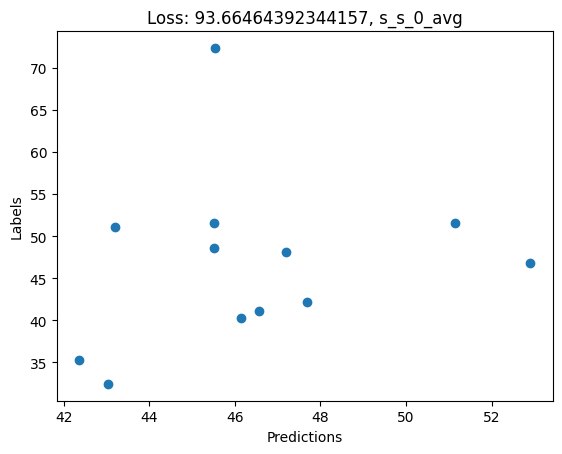

In [11]:
try:
    model, best_epoch_loss = train_model(model, criterion, exp_lr_scheduler, dataloaders=dataloaders, dataset_sizes=dataset_sizes, use_wandb=False,
                        num_epochs=100, prepare_labels = lambda x: x.to("cuda:0"),prepare_inputs=lambda x: x.to("cuda:0"), label=representation_key)
except Exception as e: 
    print(e)
    if not telegramBot.enabled:
        raise e
    telegramBot.send_telegram(f"Training failed with error message: {str(e)}")                         

# Evaluation

In [9]:
from datetime import datetime

def predictDiffs(set="val"):
    with torch.no_grad():
        n = len(dataloaders[set])
        diffs = torch.tensor([])
        for index, (inputs, labels) in enumerate(dataloaders[set]):
            #inputs = inputs.to(device)
            print(f"Infering thermostability for sample {index}/{n}...")
            labels = labels.to("cuda:1")
            outputs = model(inputs)

            _diffs = outputs.squeeze().sub(labels.squeeze()).cpu()
            diffs = torch.cat((diffs, _diffs))
            print("Diff: ", _diffs)
    return diffs
diffs = predictDiffs()

#diffs = np.array([0, 0.1, 0.2,-0.2, -0.8, 0.1])
plt.title("Differences predicted <-> actual thermostability")
plt.hist(diffs, 10)
resultsDir = "results"
now = datetime.now()
time = now.strftime("%d/%m/%Y_%H:%M:%S")
os.makedirs(resultsDir, exist_ok=True)
histFile = f"results/{time}_diffs.png"
plt.savefig(histFile)
telegramBot.send_photo(histFile, f"Differences predicted <-> actual thermostability at {time}")


Infering thermostability for sample 0/6...


KeyboardInterrupt: 

# Save model

In [ ]:
try: 
    modelPath = os.path.join(resultsDir, f"{time}_model.pth")
    torch.save(model, modelPath)
    telegramBot.send_telegram(f"Model saved at {modelPath}")
except Exception as e:
    telegramBot.send_telegram(f"Saving model failed for reason: {str(e)}")